# Lesson 1
Creating Data and spliting into features and label

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [22]:
def print_dataset(dataset):
  for window_dataset in dataset:
    for val in window_dataset:
      print(val.numpy(),end = " ")
    print()

dataset = tf.data.Dataset.range(10)
for val in dataset:
  print(val.numpy())
print("----------")
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5,shift = 1)
print_dataset(dataset)
print("----------")
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5,shift = 1,drop_remainder=True)
print_dataset(dataset)
print("----------")
#into numpy array
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
  print(window.numpy())

0
1
2
3
4
5
6
7
8
9
----------
0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 
----------
0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
----------
[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [23]:
#Spliting the data
dataset = dataset.map(lambda window: (window[:-1],window[-1:]))
for x,y in dataset:
  print(x.numpy(),y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [24]:
#Suffle
dataset = dataset.shuffle(buffer_size=10)
for x,y in dataset:
  print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[5 6 7 8] [9]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]


In [26]:
#Making batches
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())


x =  [[0 1 2 3]
 [2 3 4 5]]
y =  [[4]
 [6]]
x =  [[4 5 6 7]
 [1 2 3 4]]
y =  [[8]
 [5]]
x =  [[3 4 5 6]
 [5 6 7 8]]
y =  [[7]
 [9]]


#Sequence bias
Sequence bias is when the order of things can impact the selection of things. For example, if I were to ask you your favorite TV show, and listed "Game of Thrones", "Killing Eve", "Travellers" and "Doctor Who" in that order, you're probably more likely to select 'Game of Thrones' as you are familiar with it, and it's the first thing you see. Even if it is equal to the other TV shows. So, when training data in a dataset, we don't want the sequence to impact the training in a similar way, so it's good to shuffle them up. 

mean squared error loss function by setting loss to MSE, and my optimizer will use Stochastic Gradient Descent. I'd use this methodology instead of the raw string, so I can set parameters on it to initialize it such as the learning rate or LR and the momentum. Experiment with different values here to see if you can get your model to converge more quickly or more accurately. 

run for a 100 epochs here. Ignoring the epoch but epoch output by setting verbose to zero. 

#Lesson 2

2.4.1


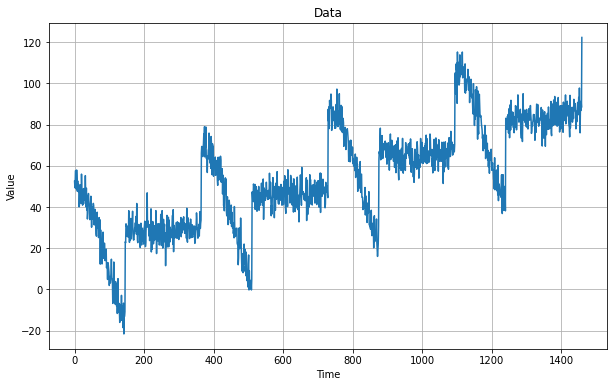

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)
plt.figure(figsize=(10,6))
plt.title("Data")
plot_series(time,series)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [30]:
#Helper Fiunction
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [34]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print("Dataset:",dataset)
l0 = tf.keras.layers.Dense(1,input_shape = [window_size])
model = tf.keras.models.Sequential([l0])
model.summary()

Dataset: <PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum= 0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layers weights {}".format(l0.get_weights()))

Layers weights [array([[-0.04670209],
       [-0.01191428],
       [ 0.0378558 ],
       [-0.01197214],
       [ 0.02169318],
       [ 0.01230427],
       [-0.01958651],
       [ 0.01161041],
       [-0.01981799],
       [ 0.033432  ],
       [-0.01336083],
       [ 0.00286246],
       [-0.04743361],
       [ 0.05226544],
       [ 0.01381658],
       [ 0.06182761],
       [ 0.01344515],
       [ 0.16180849],
       [ 0.26407292],
       [ 0.45623225]], dtype=float32), array([1.4880456], dtype=float32)]


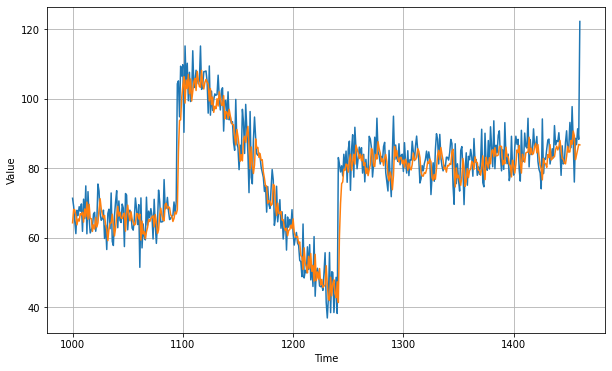

In [44]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [45]:
print("MSE: ",tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

MSE:  4.991138


1000


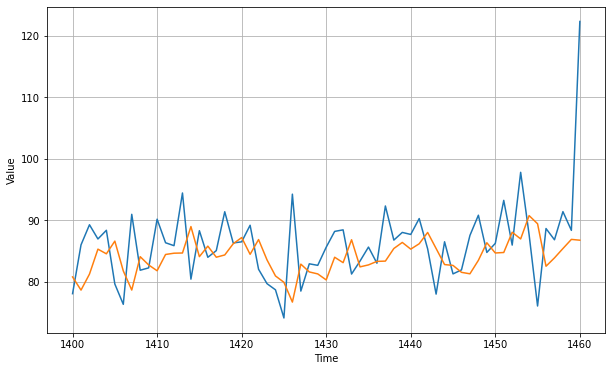

In [68]:
print(split_time)
plt.figure(figsize=(10, 6))

plot_series(time_valid[400:], x_valid[400:])
plot_series(time_valid[400:], results[400:])

#Lesson 3:
But it's also a somewhat a stab in the dark, particularly with the optimizer function. Wouldn't it be nice if we could pick the optimal learning rate instead of the one that we chose? 

A technique for that that uses callbacks.  I've added a callback to tweak the learning rate using a learning rate scheduler. You can see that code here. This will be called at the callback at the end of each epoch. What it will do is change the learning rates to a value based on the epoch number.(If epoch = 100) So in epoch 1, it is 1 times 10 to the -8 times 10 to the power of 1 over 20. And by the time we reach the 100 epoch, it'll be 1 times 10 to the -8 times 10 to the power of 5, and that's 100 over 20. This will happen on each callback because we set it in the callbacks parameter of modeled outfit.


After training with this, we can then plot the last per epoch against the learning rate per epoch by using this code, and we'll see a chart like this. The y-axis shows us the loss for that epoch and the x-axis shows us the learning rate. We can then try to pick the lowest point of the curve where it's still relatively stable like this, and that's right around 7 times 10 to the -6.

So let's set that to be our learning rate and then we'll retrain

But it's still just a DNN, there's no sequencing taken into account, and in a time series like this, the values that are immediately before a value are more likely to impact it than those further in the past. And that's the perfect set up to use RNS like we had in the natural language course.

2.4.1


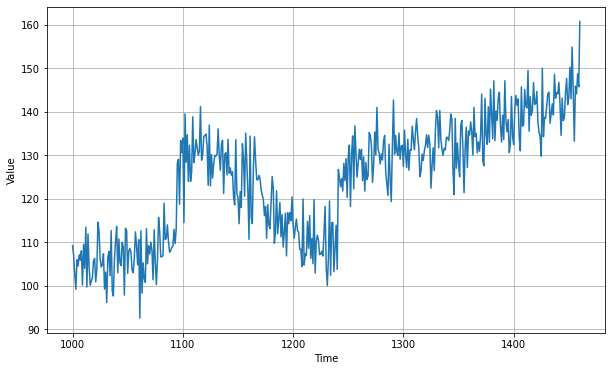

In [69]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [70]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

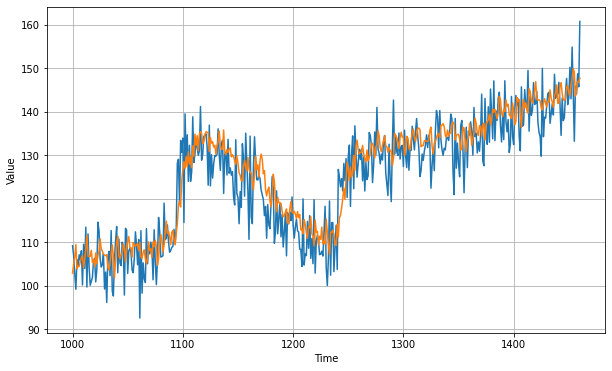

In [71]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [72]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.920931

In [73]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch/20)
)
optimizer = tf.optimizers.SGD(lr = 1e-8, momentum= 0.9)

model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

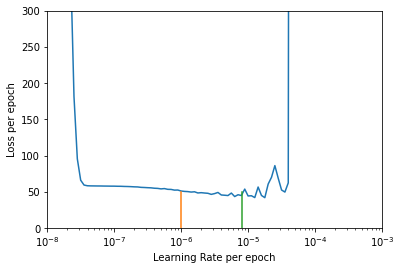

In [99]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.xlabel("Learning Rate per epoch")
plt.ylabel("Loss per epoch")
plt.axis([1e-8, 1e-3, 0 ,300])#xmin,xmax,ymin,ymax
x = []
y = []
z = []
for i in range(50):
  y.append(i)
for i in range(50):
  x.append(1e-6)
for i in range(50):
  z.append(8e-6)
plt.plot(x,y)
plt.plot(z,y)

In [100]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

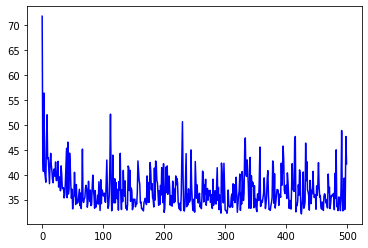

In [101]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[43.3861083984375, 40.701663970947266, 38.1958122253418, 42.26975631713867, 44.2873420715332, 41.9124755859375, 40.714839935302734, 38.9483757019043, 38.37302780151367, 41.091094970703125, 41.09366989135742, 39.697147369384766, 42.55657196044922, 38.85115051269531, 38.8072509765625, 40.52373504638672, 42.67994689941406, 37.512664794921875, 39.554325103759766, 39.39160919189453, 36.767250061035156, 41.77326583862305, 40.12632751464844, 37.254356384277344, 37.195167541503906, 37.38172912597656, 35.3344841003418, 35.9915885925293, 38.21546936035156, 41.580894470214844, 45.312957763671875, 35.377986907958984, 46.54072952270508, 36.113426208496094, 37.15962600708008, 44.329402923583984, 41.983455657958984, 37.900672912597656, 35.26444625854492, 37.100345611572266, 33.129913330078125, 35.516971588134766, 35.71597671508789, 40.48320388793945, 36.62353515625, 34.015281677246094, 38.02931594848633, 34.53874588012695, 34.29431915283203, 34.582916259765625, 35.86761474609375, 37.080596923828125, 

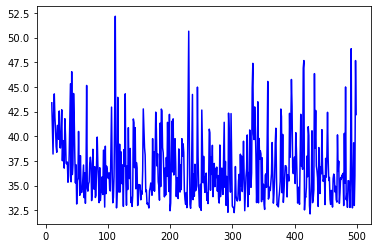

In [102]:
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

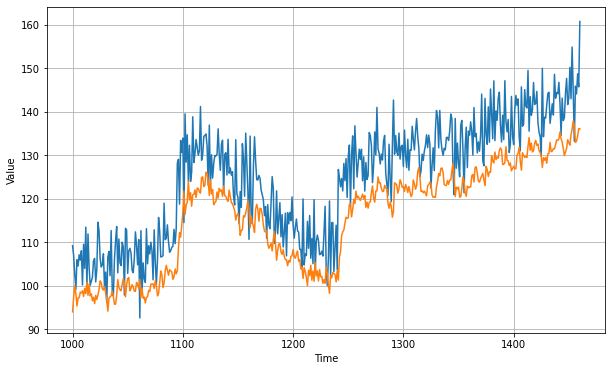

In [103]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [104]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

8.913566

#Exercise 2 - Predict with a DNN
For this exercise you’ll create your own synthetic dataset -- I’ve plotted a chart for what it should look like, see if you can figure out the parameters that get this series.

Once you have your series, you’ll create a DNN to predict values for that series!

In [105]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


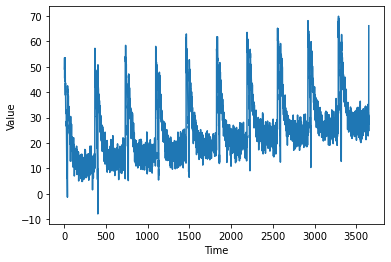

In [108]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),# YOUR CODE HERE # * np.pi),
                    2 / np.exp(9 * season_time))#YOUR CODE HERE# / np.exp(#YOUR CODE HERE# * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10# YOUR CODE HERE #
series = trend(time, 0.1)# YOUR CODE HERE#)  
baseline = 10
amplitude = 40
slope = 0.005# YOUR CODE HERE#
noise_level = 3# YOUR CODE HERE#

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [109]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [116]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"),# YOUR CODE HERE #),
    tf.keras.layers.Dense(10, activation="relu"), # YOUR CODE HERE #, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse",optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))# YOUR CODE HERE #, optimizer=# YOUR CODE HERE#))
model.fit(dataset,epochs=100,verbose=0)


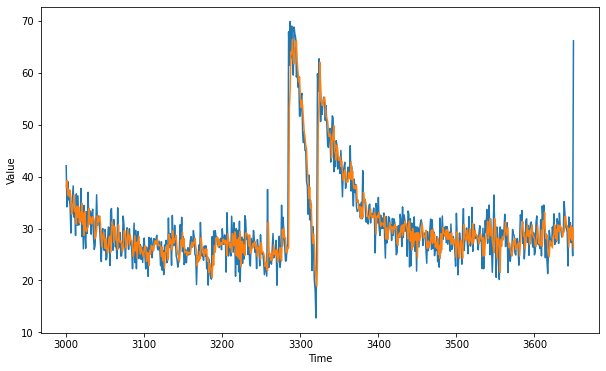

In [117]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [118]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# EXPECTED OUTPUT
# A Value less than 3

3.0630972